The goal of this project was to examine the sensitivities of different integration algorithms for a $1/r^2$ force. 

Our general equations of motions were taken to be:

$\begin{align}
\frac{d\vec{v}}{dt} = -\frac{{\mu \; \vec{r}}}{|\vec{r}|^3} \\
\frac{d\vec{r}}{dt} = \vec{v}
\end{align}$

Where $\mu$ is a some constant - think of this like normalizing $GM$ or $q^2 / m$
$\vec{v}$ is the test particle velocity & $\vec{r}$ is the particle spatial coordinate. 
Since theses ODEs are coupled they have to integrated simultaneously in order to obtain a particle trajectory

The trajectories were integrated in a right handed cartesian coordinate system 
A.K.A an (X,Y,Z)-space for those who want to talk like normal humans

The trajectories were integrated in the reference frame of the source particle such that $-\frac{{\mu}}{|\vec{r}|^2} \rightarrow \infty$ for $\vec{r} \rightarrow 0$ 
Numerically we defined $-\frac{{\mu }}{|r=0|^2}$ to throw an error in order to avoid singularities

Our first step was to define a simple function for getting the acceleration term for each vector coordinate.

This wasn't actually our first step but was done in hindsight after writing several functions. We realized that it was really helpful to make this helper function

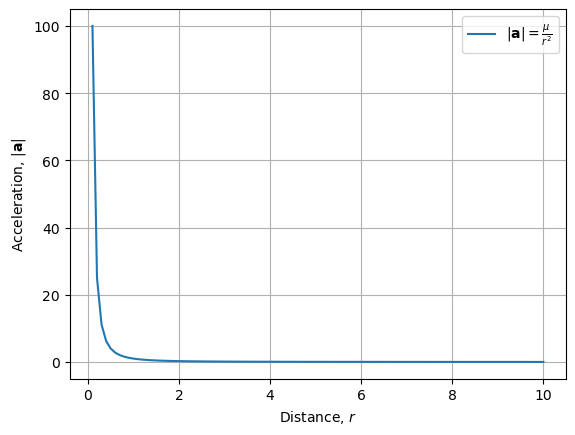

In [37]:
import numpy as np
import matplotlib.pyplot as plt

def accel(x, mu=1.0):
    r2 = np.dot(x, x)
    r = np.sqrt(r2)
    #check for singularity
    if r == 0:
        raise ValueError("Singular position: r = 0")
    return -mu * x / (r2 * r)

r = np.linspace(0.1, 10.0, 100)

a = []  
for i in r:
    pos = np.array([i, 0.0, 0.0])
    avec = accel(pos)
    amag = np.linalg.norm(avec)
    a.append(amag)

a = np.array(a) # Convert list to a NumPy array

fig, ax = plt.subplots(1, 1)
ax.plot(r,a, label=r'$|\mathbf{a}| = \frac{\mu}{r^2}$')
ax.set_xlabel(r'Distance, $r$')
ax.set_ylabel(r'Acceleration, $|\mathbf{a}|$')
ax.grid(True)
ax.legend()
plt.show()



Notice that our acceleration function is vectorized This was also something that took some time for us to realize was important. Originally we tried to integrate each component seperately 
Think $a_x = x \hat{x} / r^2$ but we realized we could make the code much more efficient this way. You can see how the original notation never changed x is still the argument

Next we dug into the main goals of our project - actually integration!

We picked three (3) different algorithms for the integration: RK4, Leapfrog, and the Yoshida algorithm. 

We'll start by showing how we implemented the RK4 scheme. This was explained pretty in depth in class so we wont repeat it here. The basic scheme is

Given the vector phase 
$\begin{align}\vec{y}_n ​= \begin{bmatrix} \vec{r}_n \\ \vec{v}_n \end{bmatrix} \end{align}$ at time $t_n$​ 
the next step is calculated by:
$\begin{align} \vec{y}_{n+1​} = \vec{y}_n ​+ 6h​(k1​+2k2​+2k3​+k4​) \end{align}$

/var/folders/v9/75qfn4mx0dq39zw7c6b_h7r40000gn/T/ipykernel_2083/2048072328.py:55: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


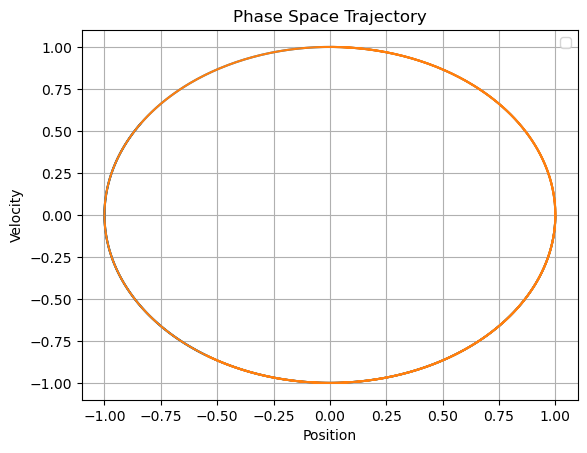

In [38]:
import numpy as np
import matplotlib.pyplot as plt

def accel(x, mu=1.0):
    r2 = np.dot(x, x)
    r = np.sqrt(r2)
    #check for singularity
    if r == 0:
        raise ValueError("Singular position: r = 0")
    return -mu * x / (r2 * r)

def rk4_step(x, v, h, mu = 1.0):

    k1x = v
    k1v = accel(x)

    k2x = v + 0.5 * h * k1v
    k2v = accel(x + 0.5 * h * k1x)

    k3x = v + 0.5 * h * k2v
    k3v = accel(x + 0.5 * h * k2x)

    k4x = v + h * k3v
    k4v = accel(x + h * k3x)

    x_new = x + (h / 6.0) * (k1x + 2*k2x + 2*k3x + k4x)
    v_new = v + (h / 6.0) * (k1v + 2*k2v + 2*k3v + k4v)
    return x_new, v_new

mu = 1.0
h = 0.01
N = 1000
x0 = [1.0, 0.0, 0.0]
v0 = [0.0, 1.0, 0.0]

x = np.array(x0, dtype=float)
v = np.array(v0, dtype=float)

positions = []
velocities = []
for _ in range(N):
    x, v = rk4_step(x, v, h, mu)
    positions.append(x.copy())
    velocities.append(v.copy())

q = np.array(positions)
qdot = np.array(velocities)

fig, ax = plt.subplots(1, 1)
ax.plot(q,qdot)
ax.set_xlabel('Position')
ax.set_ylabel('Velocity')
ax.set_title('Phase Space Trajectory')
ax.grid(True)
ax.legend()
plt.show()

Next we did the leapfrog scheme 

Leapfrog:

First Velocity Half-Step
$\begin{align} \vec{v}_{n+1/2} ​= \vec{v}_n ​+ \frac{1}{2} h \vec{​a}(\vec{r}_n​) \end{align}$

Position Update
$\begin{align} \vec{r}_{n+1} ​= \vec{r}_n ​+  h \vec{​v}_{n+1/2} \end{align}$

Next Velocity Half-Step:
$\begin{align} \vec{v}_{n+1} ​= \vec{v}_{n+1/2} ​+ \frac{1}{2} h \vec{​a}(\vec{r}_{n+1/2}​) \end{align}$
vn+1​=vn+1/2​+2h​a(rn+1​)

/var/folders/v9/75qfn4mx0dq39zw7c6b_h7r40000gn/T/ipykernel_2083/1301159185.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


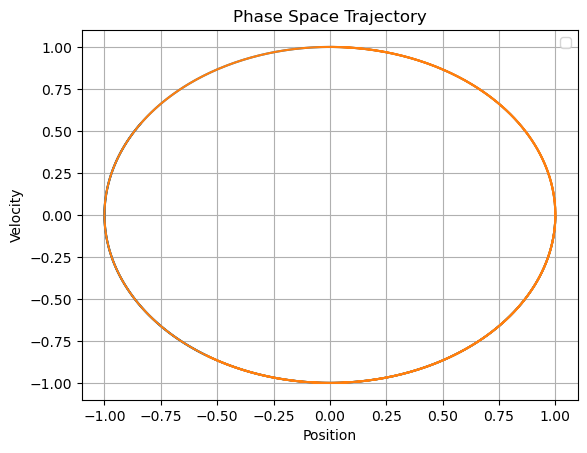

In [39]:
import numpy as np
import matplotlib.pyplot as plt

def accel(x, mu=1.0):
    r2 = np.dot(x, x)
    r = np.sqrt(r2)
    #check for singularity
    if r == 0:
        raise ValueError("Singular position: r = 0")
    return -mu * x / (r2 * r)

def leapfrog_step(x, v, h, mu = 1.0):
    a = accel(x)
    v_half = v + 0.5 * h * a
    x_new = x + h * v_half
    a_new = accel(x_new)
    v_new = v_half + 0.5 * h * a_new
    return x_new, v_new

mu = 1.0
h = 0.01
N = 1000
x0 = [1.0, 0.0, 0.0]
v0 = [0.0, 1.0, 0.0]

x = np.array(x0, dtype=float)
v = np.array(v0, dtype=float)

positions = []
velocities = []
for _ in range(N):
    x, v = leapfrog_step(x, v, h, mu)
    positions.append(x.copy())
    velocities.append(v.copy())

q = np.array(positions)
qdot = np.array(velocities)

fig, ax = plt.subplots(1, 1)
ax.plot(q,qdot)
ax.set_xlabel('Position')
ax.set_ylabel('Velocity')
ax.set_title('Phase Space Trajectory')
ax.grid(True)
ax.legend()
plt.show()

So we learned about this from the AI. We asked it what some common algorithms for this type of problem were and it recommend the RK4 scheme and the Leapfrog scheme that we knew and then a new one the 4 step Yoshida algorithm. It reminded us sort of RK4. Apparently it also borrows from the leapfrog algorithm too. 

There are 2 sets of yoshida coefficients defined as $c_i$ and $d_i$. The c's are for the position updates and the d's are for the velocity. This is the part that is like the RK4 scheme, we're averaging over different tangent lines.


$\begin{align}
    w_0 \equiv -\frac{2^{1/3}}{2 - 2^{1/3}}, \\
    w_1 \equiv \frac{1}{2 - 2^{1/3}}, \\
    \\
    c_1 = c_4 = \frac{w_1}{2}, \\
    c_2 = c_3 = \frac{w_0 + w_1}{2}, \\
    d_1 = d_3 = w_1, \\
    d_2 = w_0 \\
    d_4 = 0
\end{align}$

Notice in the $d_i$ coefficients there are technically only 3 since $d_4 = 0$. This reminded us of the leapfrog. One of the vectors is used as intermediary to get to the important step. 
$\begin{align}
  x_{i}^{1} = x_{i} + c_1 v_{i} h, \\
  v_{i}^{1} = v_{i} + d_1 a(x_{i}^{1}) h, \\
  \\
  x_{i}^{2} = x_{i}^{1} + c_2 v_{i}^{1} h, \\
  v_{i}^{2} = v_{i}^{1} + d_2 a(x_{i}^{2}) h, \\
  \\
  x_{i}^{3} = x_{i}^{2} + c_3 v_{i}^{2} h, \\
  v_{i}^{3} = v_{i}^{2} + d_3 a(x_{i}^{3}) h, \\
  \\
  x_{i+1} = x_{i}^{4} = x_{i}^{3} + c_4 v_{i}^{3} h, \\
  v_{i+1} = v_{i}^{4} = v_{i}^{3} + d_4 a(x_{i+1}) h
\end{align}$

/var/folders/v9/75qfn4mx0dq39zw7c6b_h7r40000gn/T/ipykernel_2083/3379153801.py:57: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


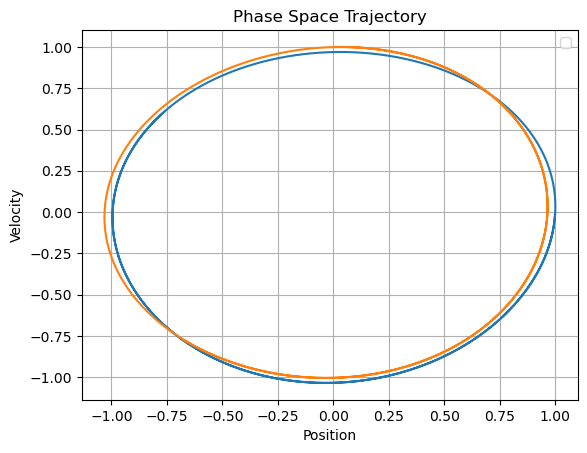

In [40]:
import numpy as np
import matplotlib.pyplot as plt

def accel(x, mu=1.0):
    r2 = np.dot(x, x)
    r = np.sqrt(r2)
    #check for singularity
    if r == 0:
        raise ValueError("Singular position: r = 0")
    return -mu * x / (r2 * r)

def yoshida4_step(x, v, h, mu=1.0):

    w1 = 1.0 / (2.0 - 2.0**(1.0/3.0))
    w0 = - (2.0**(1.0/3.0)) / (2.0 - 2.0**(1.0/3.0))
    c = np.zeros(5)
    d = c
    c[0] = w1/2
    c[1] = (w0+w1)/2
    c[2] = (w0+w1)/2
    c[3] = w1/2
    d[0] = w1
    d[1] = w0
    d[2] = w1
    d[3] = 0.0

    for i in range(4):
        v = v + d[i] * h * accel(x)
        x = x + c[i] * h * v
    return x, v

mu = 1.0
h = 0.01
N = 1000
x0 = [1.0, 0.0, 0.0]
v0 = [0.0, 1.0, 0.0]

x = np.array(x0, dtype=float)
v = np.array(v0, dtype=float)

positions = []
velocities = []
for _ in range(N):
    x, v = yoshida4_step(x, v, h, mu)
    positions.append(x.copy())
    velocities.append(v.copy())

q = np.array(positions)
qdot = np.array(velocities)

fig, ax = plt.subplots(1, 1)
ax.plot(q,qdot)
ax.set_xlabel('Position')
ax.set_ylabel('Velocity')
ax.set_title('Phase Space Trajectory')
ax.grid(True)
ax.legend()
plt.show()